In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_CUBIC_OG, CCA_MarkovChain_Hybla_discrete, CCA_MarkovChain_Hybla, CCA_MarkovChain_CUBIC_new, CCA_StochasticModel_Hybla

#plt.rcParams['text.usetex'] = True
plt.rcParams.update(plt.rcParamsDefault)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [6]:

wired = CCA_StochasticModel_Hybla(RTT=0.5,p=0.00005,b=0.1/0.5,C=1000,T0 = 1)
wired.ssThroughput()/(500)

1.5489087857464632

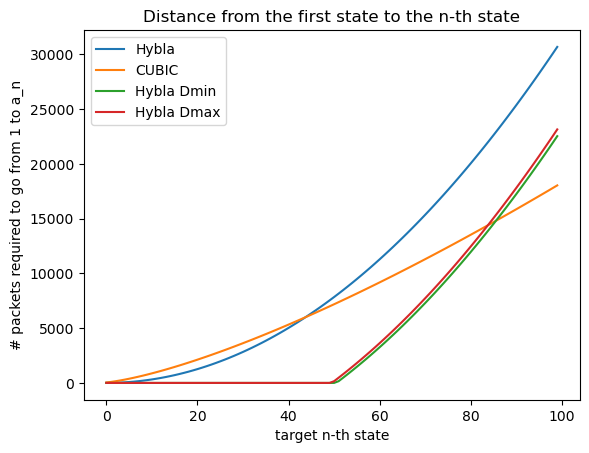

1.0
157.0


In [10]:
hyb = CCA_MarkovChain_Hybla_discrete(packet_err=0.0006,beta=0.5,N=100,C =1000, RTT_est=0.2, RTT_real = 0.5, RTT0=0.1)
cub = CCA_MarkovChain_CUBIC_new(packet_err = 0.0006, beta=0.5,N=100,C =1000, RTT_est=0., RTT_real = 0.5,alpha=0.001)

a = 1
d = np.zeros(100)
dc = np.zeros(100)
for i,ai in enumerate(hyb.a):
    d[i] = hyb.D(1,ai)
for i,ai in enumerate(cub.a):
    dc[i] = cub.D(1,ai)
plt.title("Distance from the first state to the n-th state")
plt.ylabel("# packets required to go from 1 to a_n")
plt.xlabel("target n-th state")
plt.plot(d,label="Hybla") 
plt.plot(dc,label="CUBIC")
plt.plot(hyb.Dmin[50,:], label = "Hybla Dmin")
plt.plot(hyb.Dmax[50,:], label = "Hybla Dmax")
plt.legend()             
plt.show()
print(hyb.Dmin[50,50])
print(hyb.Dmax[50,50])

Average throughput is 0.04668252355614676


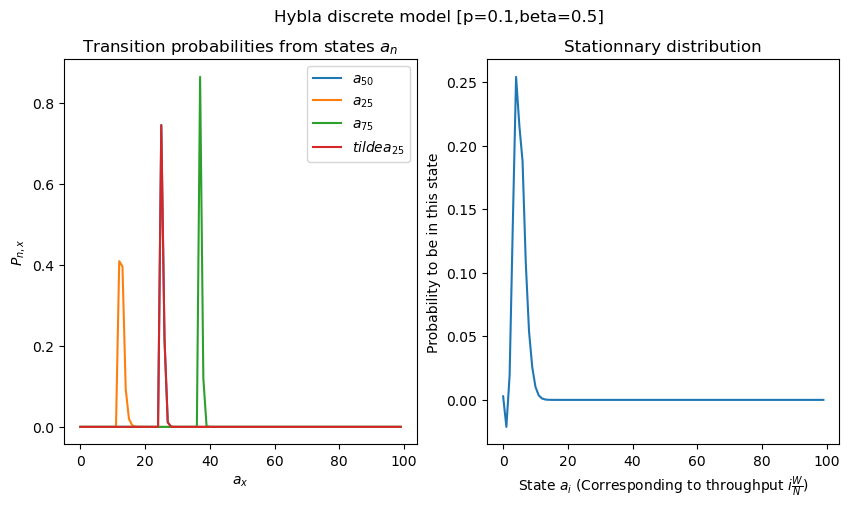

In [2]:
p = 0.1
b = 0.5
wired = CCA_MarkovChain_Hybla_discrete(packet_err=p,beta=b,N=100,C =1000, RTT_est=0.2, RTT_real = 0.21, RTT0=0.1)
wired.avg_throughput()
print(f"Average throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].plot(np.arange(wired.N),wired.Ptilde[25,:],label = "$tilde a_{25}$")
axs[0].set_title(r"Transition probabilities from states $a_n$")
axs[0].set_ylabel(r"$P_{n,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle(f"Hybla discrete model [p={p},beta={b}]")
plt.show()

0.0 7.450580596923828e-09
0.0 0.057972772657612096
0.0 0.3237252125371928
0.0 0.2395293496859423
0.0 0.052113930348505755
0.0 0.0054703854621200865


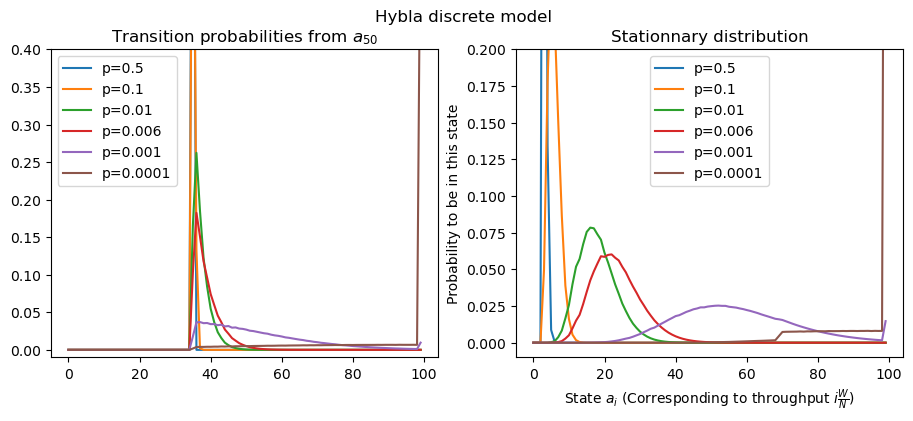

In [3]:
wired = CCA_MarkovChain_Hybla_discrete(packet_err=0.1,beta=0.7,N=100,C = 1000,RTT_est=0.2, RTT_real = 0.21, RTT0=0.1)
ps = [0.5,0.1,0.01,0.006,0.001,0.0001]
fig, axs = plt.subplots(1, 2, figsize=(13,5))
for i in ps:
    wired.packet_err = i
    wired.compute_stationnary_distribution()
    axs[0].plot(np.arange(wired.N),wired.P[50,:],label=f"p={i}")
    axs[1].plot(np.arange(wired.N),wired.pi,label=f"p={i}")
    print(wired.P[50,25], wired.Ptilde[50,51])

axs[1].set_title(r"Stationnary distribution")
axs[0].set_title(r"Transition probabilities from $a_{50}$")
axs[1].set_ylim(-0.01,0.2)
axs[0].set_ylim(-0.01,0.4)
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
axs[1].legend()
axs[0].legend()
fig.suptitle(f"Hybla discrete model")
plt.show()

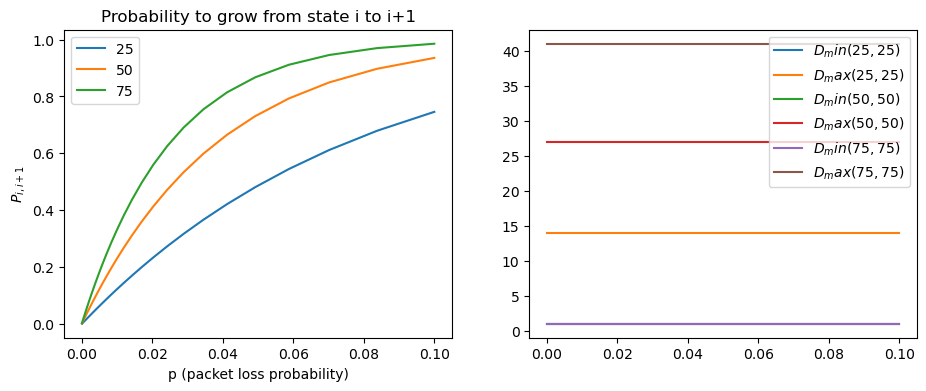

In [4]:
hyb = CCA_MarkovChain_Hybla_discrete(packet_err=0.0006,beta=0.7,N=100,C =1000, RTT_est=0.2, RTT_real = 0.21, RTT0=0.1)
probij = np.zeros((40,3))
ps = np.logspace(-4,-1,40)
probe_states = [25,50,75]
d_mins = np.zeros((40,3))
d_maxs = np.zeros((40,3))
for i,p in enumerate(ps):
    hyb.packet_err = p
    hyb.compute_stationnary_distribution()
    for j,start in enumerate(probe_states):
        probij[i,j] = hyb.Ptilde[start,start]
        d_mins[i,j] = hyb.Dmin[start,start]
        d_maxs[i,j] = hyb.Dmax[start,start]
#also do a plot for the nmin and nmax starting from these 3 states,
fig, axs = plt.subplots(1, 2, figsize=(11,4))
for a,b in enumerate(probe_states):
    axs[1].plot(ps,d_mins[:,a],label = f"$D_min({b},{b})$")
    axs[1].plot(ps,d_maxs[:,a],label = f"$D_max({b},{b})$")
    axs[0].plot(ps,probij[:,a], label = f"{b}")
axs[0].set_title("Probability to grow from state i to i+1")
axs[0].set_xlabel("p (packet loss probability)")
axs[0].set_ylabel("$P_{i,i+1}$")
axs[0].legend()
axs[1].legend()

In [19]:
print(hyb.a[1],hyb.a[4])
print(hyb.a[2]-0.5*hyb.a[5])
print(hyb.T(hyb.a[1],hyb.a[5]))
#self.RTT0**2*(y-self.beta*x)/self.RTT_real
(5-0.5)*hyb.W/hyb.N

15.75 47.25
-2.625
0.05250000000000008


47.25

3.621964664966512
6.020404329078785


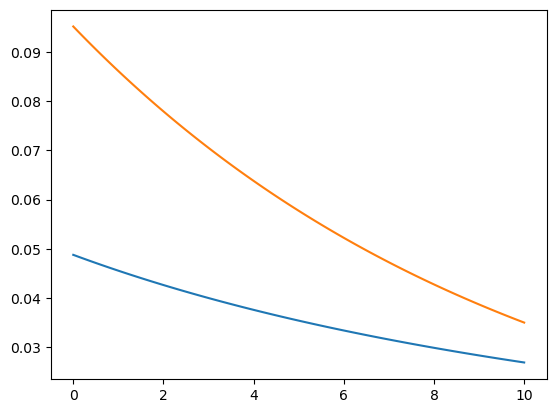

In [23]:
t = np.linspace(0,10,100)
w0 = 100
rtt = 0.5
l = 1/10
e = 0.1
w = w0+t/rtt # cwnd in MSS
b = w/rtt # MSS/s

p = np.exp(-t/(e*b))-np.exp(-(t+1)/(e*b))
pold = np.exp(-l*t)-np.exp(-l*(t+1))

plt.plot(t,p)
plt.plot(t,pold)
print(np.sum(np.exp(-t/(e*b))-np.exp(-(t+1)/(e*b))))
print(np.sum(np.exp(-l*t)-np.exp(-l*(t+1))))

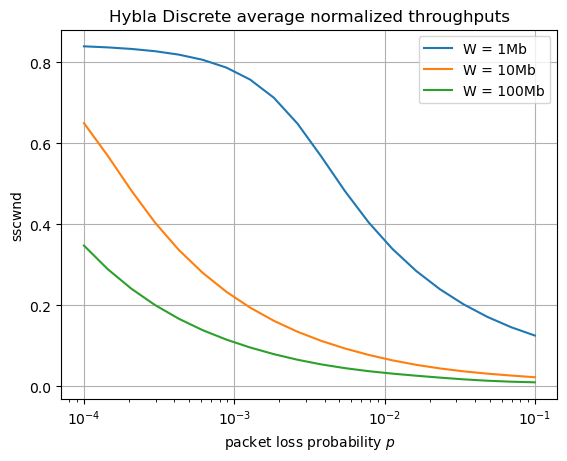

In [5]:
err_rates = np.logspace(-4,-1,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([100,500,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_discrete(packet_err=l,beta=0.7,N=100,C = C,RTT_real=0.5, RTT0=0.025)
        throughputs[k,i] = wireless.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Hybla Discrete average normalized throughputs")
plt.xlabel(r"packet loss probability $p$")
plt.ylabel(r'sscwnd')
plt.show()

Average throughput is 0


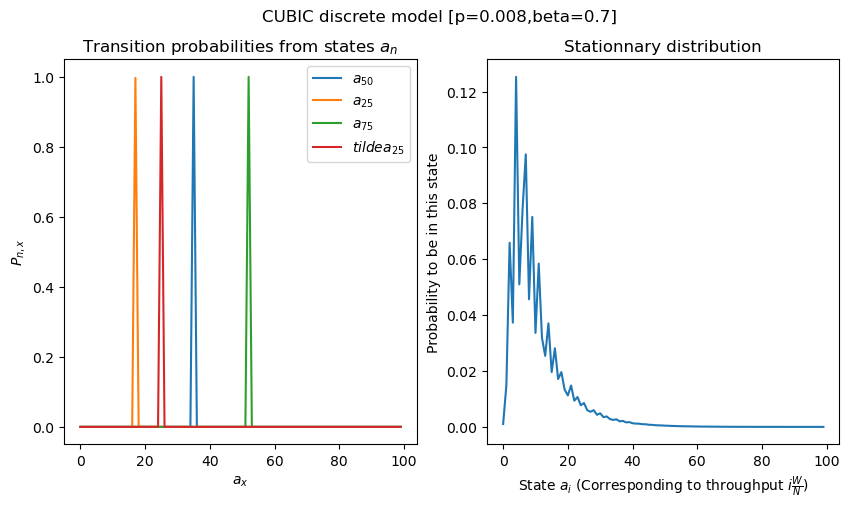

In [2]:
p = 0.008
b = 0.7
wired = CCA_MarkovChain_CUBIC_new(packet_err=p,beta=b,N=100,C =1000, RTT_est=0.2, RTT_real = 0.21)
wired.avg_throughput()
print(f"Average throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].plot(np.arange(wired.N),wired.Ptilde[25,:],label = "$tilde a_{25}$")
axs[0].set_title(r"Transition probabilities from states $a_n$")
axs[0].set_ylabel(r"$P_{n,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle(f"CUBIC discrete model [p={p},beta={b}]")
plt.show()

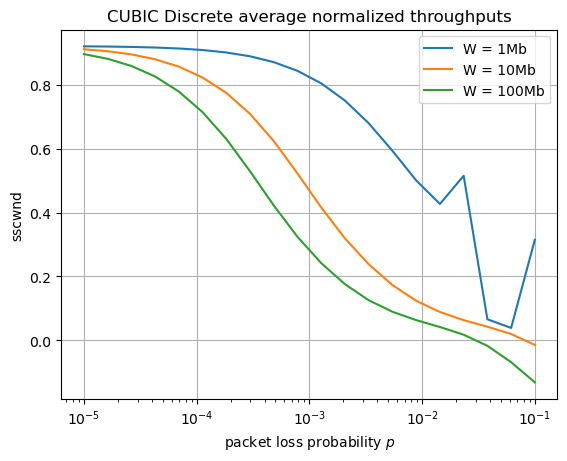

In [3]:
err_rates = np.logspace(-5,-1,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([100,500,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_CUBIC_new(packet_err=l,beta=0.7,N=100,C = C,RTT_real=0.5)
        throughputs[k,i] = wireless.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"CUBIC Discrete average normalized throughputs")
plt.xlabel(r"packet loss probability $p$")
plt.ylabel(r'sscwnd')
plt.show()

How do they depend on different RTTs?

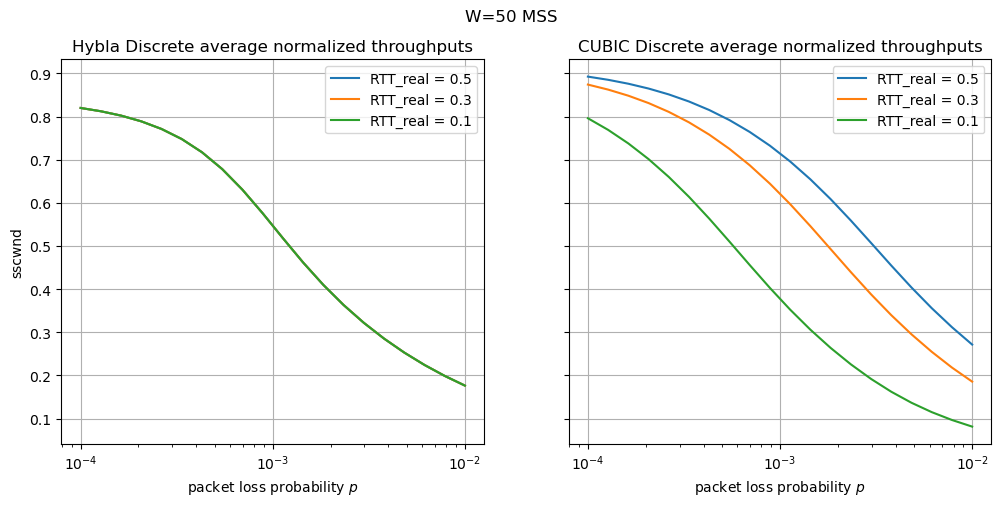

In [4]:
err_rates = np.logspace(-4,-2,20)
RTTs = [0.5,0.3,0.1]
throughputs = np.zeros([len(RTTs),len(err_rates),2])

for k,R in enumerate(RTTs):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_discrete(packet_err=l,beta=0.7,N=100,C = 100,RTT_real=R, RTT0=0.025, W = 100)
        cubic = CCA_MarkovChain_CUBIC_new(packet_err=l,beta=0.7,N=100,C = 100,RTT_real=R, W = 100)
        throughputs[k,i,0] = wireless.avg_throughput()
        throughputs[k,i,1] = cubic.avg_throughput()

fig, axs = plt.subplots(1, 2, figsize=(12,5),sharey=True)
for k,R in enumerate(RTTs):
    axs[0].plot(err_rates,throughputs[k,:,0], label = f"RTT_real = {R}")
    axs[1].plot(err_rates,throughputs[k,:,1], label = f"RTT_real = {R}")
axs[0].semilogx()
axs[0].legend()
axs[0].grid()
axs[0].set_title(r"Hybla Discrete average normalized throughputs")
axs[0].set_xlabel(r"packet loss probability $p$")
axs[0].set_ylabel(r'sscwnd')
axs[1].semilogx()
axs[1].legend()
axs[1].grid()
axs[1].set_title(r"CUBIC Discrete average normalized throughputs")
axs[1].set_xlabel(r"packet loss probability $p$")
fig.suptitle("W=100 MSS")
plt.show()